# Cancer Diagnosis Model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn
import time
import seaborn as sns

from IPython.display import display
pd.options.display.max_columns = None

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

Attribute Information:

1. Sample code number: id number 
2. Clump Thickness: 1 - 10 
3. Uniformity of Cell Size: 1 - 10 
4. Uniformity of Cell Shape: 1 - 10 
5. Marginal Adhesion: 1 - 10 
6. Single Epithelial Cell Size: 1 - 10 
7. Bare Nuclei: 1 - 10 
8. Bland Chromatin: 1 - 10 
9. Normal Nucleoli: 1 - 10 
10. Mitoses: 1 - 10 
11. Class: (2 for benign, 4 for malignant)

In [36]:
path = 'http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
colnames = ['ID', 'Clump Thickness', 'Cell Size', 'Cell Shape', 'Marginal Adhesion', 
            'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']
data = pd.read_csv(path, header=None)
df = pd.DataFrame(data)
df.columns = colnames

print(df.describe())

# why doesn't columns=colnames in pd.DataFrame work here???

                 ID  Clump Thickness   Cell Size  Cell Shape  \
count  6.990000e+02       699.000000  699.000000  699.000000   
mean   1.071704e+06         4.417740    3.134478    3.207439   
std    6.170957e+05         2.815741    3.051459    2.971913   
min    6.163400e+04         1.000000    1.000000    1.000000   
25%    8.706885e+05         2.000000    1.000000    1.000000   
50%    1.171710e+06         4.000000    1.000000    1.000000   
75%    1.238298e+06         6.000000    5.000000    5.000000   
max    1.345435e+07        10.000000   10.000000   10.000000   

       Marginal Adhesion  Single Epithelial Cell Size  Bland Chromatin  \
count         699.000000                   699.000000       699.000000   
mean            2.806867                     3.216023         3.437768   
std             2.855379                     2.214300         2.438364   
min             1.000000                     1.000000         1.000000   
25%             1.000000                     2.000000

In [37]:
# There is a ? in the dataset that we have to remove
print(df.isin(['?']).sum())

df = df[df['Bare Nuclei'] !='?']
print(df.shape)

ID                              0
Clump Thickness                 0
Cell Size                       0
Cell Shape                      0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64
(683, 11)


In [38]:
print(df.isnull().sum())

ID                             0
Clump Thickness                0
Cell Size                      0
Cell Shape                     0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64


In [39]:
# recode class to binary
df.Class = np.where(df.Class==4, 1, 0)

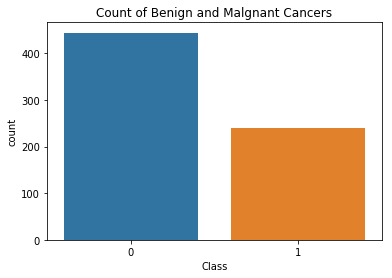

0    444
1    239
Name: Class, dtype: int64


In [40]:
# check out the classes 
sns.countplot(df.Class)
plt.title('Count of Benign and Malgnant Cancers')
plt.show()
print(df.Class.value_counts())

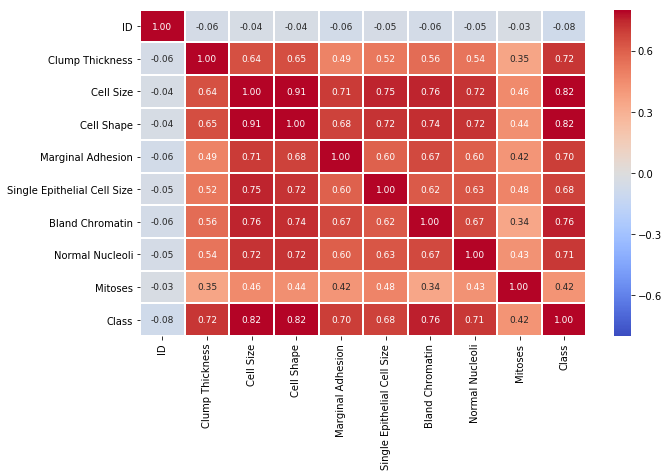

In [15]:
# check correlation
fig = plt.figure(1, figsize=(10, 6))
corrmat = df.corr()
sns.heatmap(corrmat, cmap='coolwarm', vmin=-.8, vmax=0.8, linewidth=1, 
            annot=True, annot_kws={"size": 9}, fmt='0.2f')
plt.show()

With such high correlation let's start with fitting a Random Forest Model

In [41]:
# split data
xtrain, xtest, ytrain, ytest = train_test_split(df.drop('Class',1), df.Class, test_size=.2)

In [45]:
# Initialize and fit model
rfc = RandomForestClassifier()
rfc.fit(xtrain, ytrain)

# Score test
print('Test score: {}'.format(rfc.score(xtest, ytest)))

# Predict test
pred = rfc.predict(xtest)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(ytest, pred).ravel()
print('Confusion Matrix:')
print(confusion_matrix(ytest, pred))

# Classification Report
print(classification_report(ytest, pred))

Test score: 0.9781021897810219
Confusion Matrix:
[[88  0]
 [ 3 46]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        88
           1       1.00      0.94      0.97        49

   micro avg       0.98      0.98      0.98       137
   macro avg       0.98      0.97      0.98       137
weighted avg       0.98      0.98      0.98       137



In [51]:
topfeats = pd.DataFrame(rfc.feature_importances_, index=xtrain.columns, 
                        columns=['importance']).sort_values(by='importance', ascending=False)
print(topfeats)

                             importance
Cell Size                      0.255336
Single Epithelial Cell Size    0.162288
Normal Nucleoli                0.140113
Cell Shape                     0.113701
Bland Chromatin                0.084709
Marginal Adhesion              0.077117
Bare Nuclei                    0.072755
Clump Thickness                0.062552
ID                             0.026356
Mitoses                        0.005074


The Random Forest model performed very well with this dataset. Since the dataset was nice and clean to begin with we didn't have much work to do prior to modelling.  The high multicollinearity shouldn't be much of a problem for the Random Forest, which is why we selected that model.

From the feature importance list we can see that cell size is the most important factor for determining whether or not an individual will be diagnosed.